# Gradient Boosting

In [5]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import scikitplot as skplt
# Preprocesado y modelado
# ==============================================================================
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import multiprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

import pickle

# Configuración warnings
# ==============================================================================
import warnings

In [6]:
def evaluate_model(y_test, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_test, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(y_test, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(y_test, ypred)))

### Descargamos el entrenamiento y el test

In [7]:
X_train_lasso = pd.read_parquet("X_train_lasso.parquet")
y_train = pd.read_parquet("y_train.parquet")
X_test_lasso = pd.read_parquet("X_test_lasso.parquet")
y_test = pd.read_parquet("y_test.parquet")

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'max_features'  : ['auto'],
              'max_depth'     : [None, 10], #20, #3, #1
              'subsample'     : [0.5, 1],
              'learning_rate' : [ 0.1] #0.001
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = GradientBoostingClassifier(
                        n_estimators        = 200, 
                        random_state        = 0,
                        # Activación de la parada temprana
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_lasso, y = y_train)

In [7]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,param_max_features,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.1,None,auto,0.5,-0.384155,0.000232,-0.383910,0.000109
1,0.1,None,auto,1,-0.384192,0.000228,-0.383904,0.000108
2,0.1,10,auto,0.5,-0.384332,0.000243,-0.384069,0.000127
3,0.1,10,auto,1,-0.384464,0.000263,-0.384282,0.000078


In [5]:
# Mejores hiperparámetros por validación cruzada
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': None, 'max_features': 'auto', 'subsample': 0.5} : -0.3841548378438937 neg_root_mean_squared_error


In [18]:
# Error de test del modelo final
GradientBoosting_CLF = grid.best_estimator_
predicciones = GradientBoosting_CLF.predict(X = X_test_lasso,)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.38386934654952637


In [9]:
# Cargamos el modelo para no tener que entrenarlo otra vez
warnings.filterwarnings('ignore')
with open('Gradientboosting.pkl', 'rb') as f:
    GradientBoosting_CLF = pickle.load(f)

In [10]:
ypred = GradientBoosting_CLF.predict(X_test_lasso)
ypred_proba = GradientBoosting_CLF.predict_proba(X_test_lasso)

In [11]:
print("Classification report:")
print(classification_report(y_test, ypred))

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92   1440322
           1       0.66      0.24      0.35    288210

    accuracy                           0.85   1728532
   macro avg       0.76      0.61      0.64   1728532
weighted avg       0.83      0.85      0.82   1728532



In [12]:
recall_score(y_test, ypred)

0.2426598660698796

In [13]:
precision_score(y_test, ypred)

0.6574694706363456

### Matriz de confusión

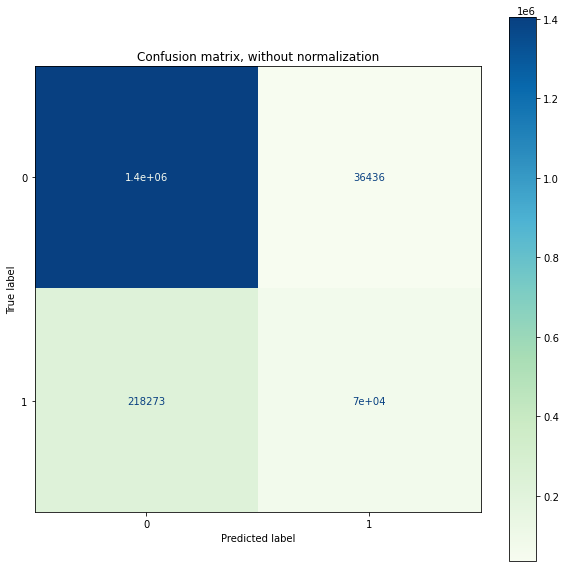

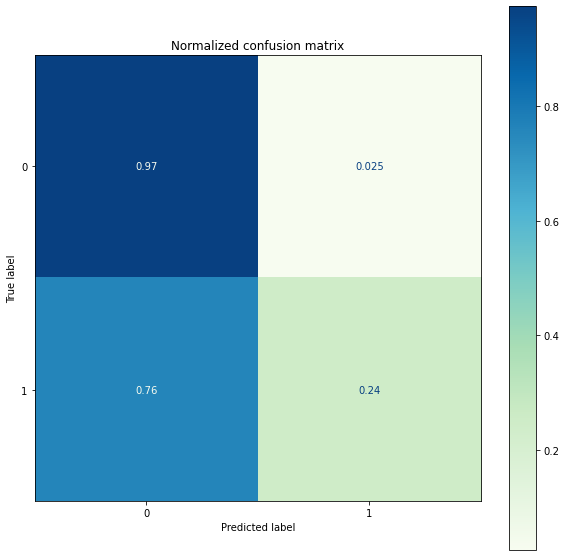

In [14]:
# Matrices de confusiones
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(y_test, ypred,
                                                       cmap=plt.cm.GnBu,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

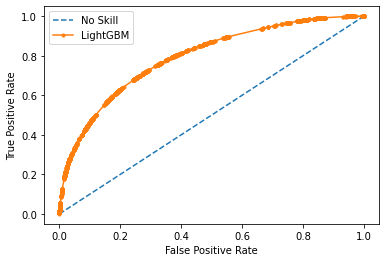

In [15]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [16]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [17]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.164507, G-Mean=0.718


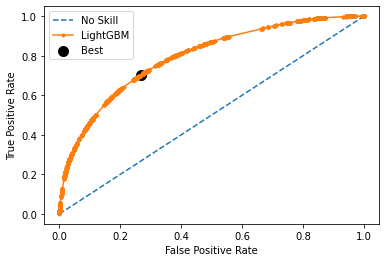

In [18]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [19]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

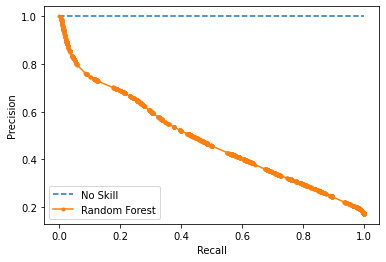

In [21]:
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.249801, F-Score=0.483


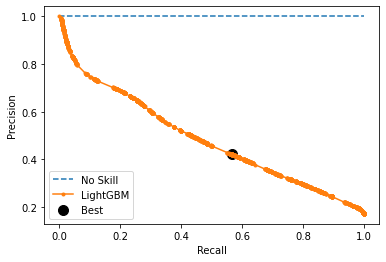

In [22]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LightGBM')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [23]:
# evaluate the model
score = f1_score(y_test, ypred)
print('F-Score: %.5f' % score)

F-Score: 0.35449


In [25]:
evaluate_model(y_test, ypred, ypred_proba)

ROC-AUC score of the model: 0.7942645635254075
Accuracy of the model: 0.8526443247796396

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92   1440322
           1       0.66      0.24      0.35    288210

    accuracy                           0.85   1728532
   macro avg       0.76      0.61      0.64   1728532
weighted avg       0.83      0.85      0.82   1728532




## Guardamos los resultados del modelo

In [27]:
with open('Gradientboosting.pkl', 'wb') as f:
    pickle.dump(GradientBoosting_CLF, f)